In [1]:
import os
import sys

sys.path.append('./src/')

import IPython
import IPython.display

import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

import yfinance as yf

#Helpers
from WindowGenerator import WindowGenerator
from models import compile_and_fit
from models import Baseline, ResidualWrapper

BTC = yf.download(tickers='BTC-USD', start='2014-09-17', end='2024-09-30')

[*********************100%%**********************]  1 of 1 completed


In [2]:
#Copy Data
df = BTC.copy(deep=True)[['High']]

#Split Data
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

#Normalize
#TODO USING MOVING AVERAGE
# train_mean = train_df.mean()
# train_std = train_df.std()

# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

train_df = train_df/train_df.max()
val_df = val_df/val_df.max()
test_df = test_df/test_df.max()

In [3]:
single_step_window = WindowGenerator(train_df=train_df, val_df=val_df, test_df=test_df,
                     input_width=14, label_width=14, shift=1, label_columns=['High'])

single_step_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label column name(s): ['High']

In [4]:
train_performance = {}
val_performance = {}
performance = {}

22/22 [==============================] - 0s 2ms/step - loss: 1.3092e-04 - mean_absolute_error: 0.0106


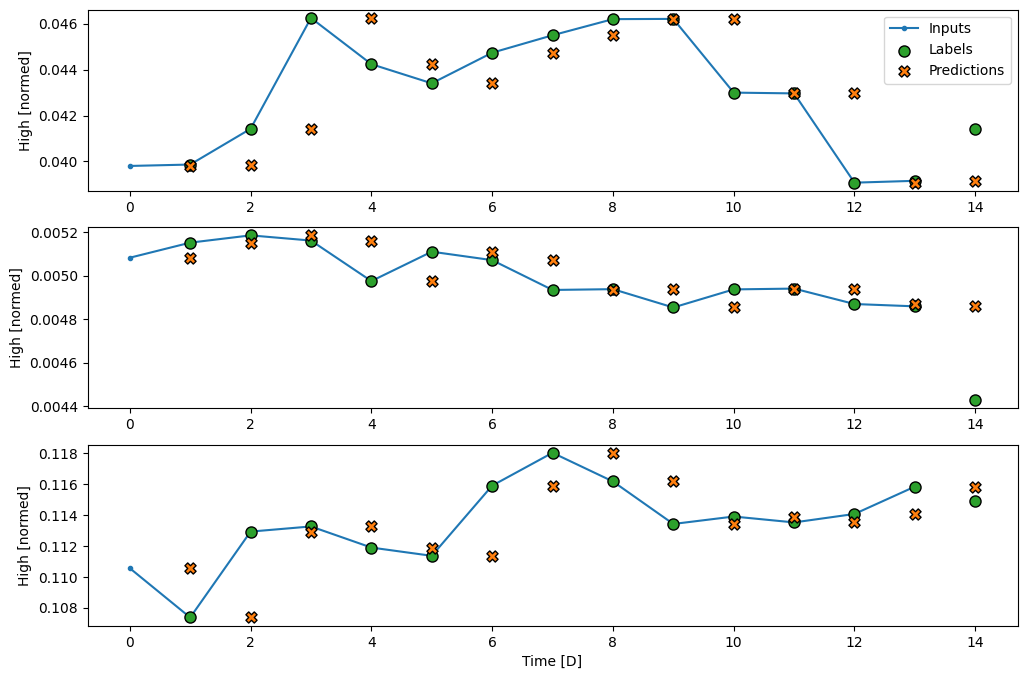

In [5]:
baseline = Baseline(label_index=single_step_window.column_indices['High'])

history = compile_and_fit(baseline, single_step_window)
IPython.display.clear_output()

train_performance['Baseline'] = baseline.evaluate(single_step_window.train, return_dict=True)
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0, return_dict=True)
single_step_window.plot(baseline)

22/22 [==============================] - 0s 3ms/step - loss: 1.3379e-04 - mean_absolute_error: 0.0108


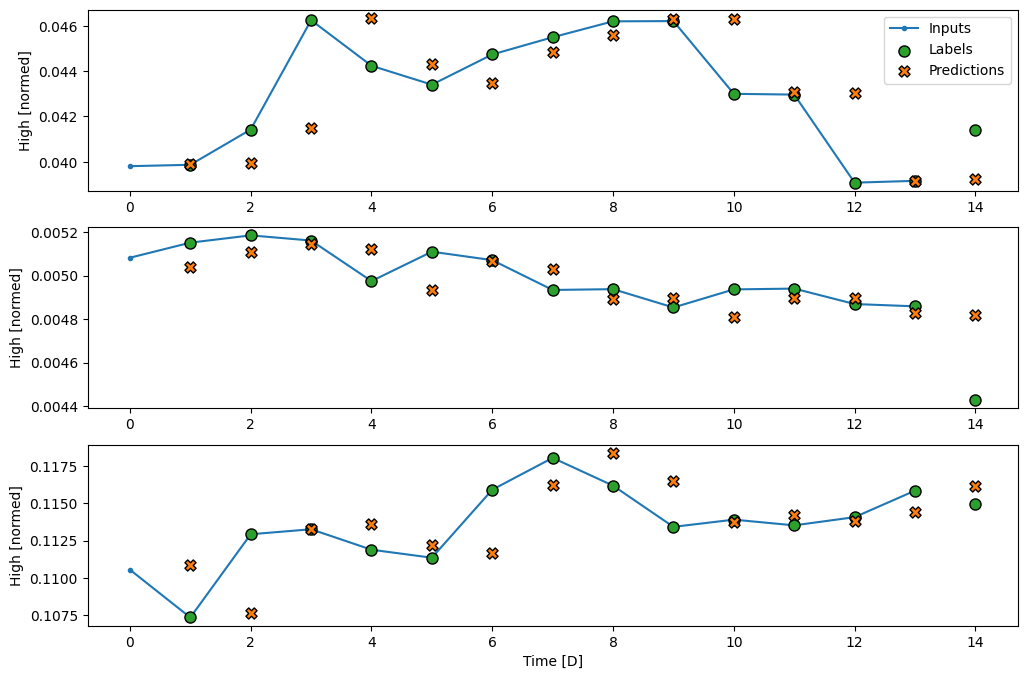

In [6]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

IPython.display.clear_output()

train_performance['Linear'] = linear.evaluate(single_step_window.train, return_dict=True)
val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)
single_step_window.plot(linear)

22/22 [==============================] - 0s 4ms/step - loss: 1.3977e-04 - mean_absolute_error: 0.0113


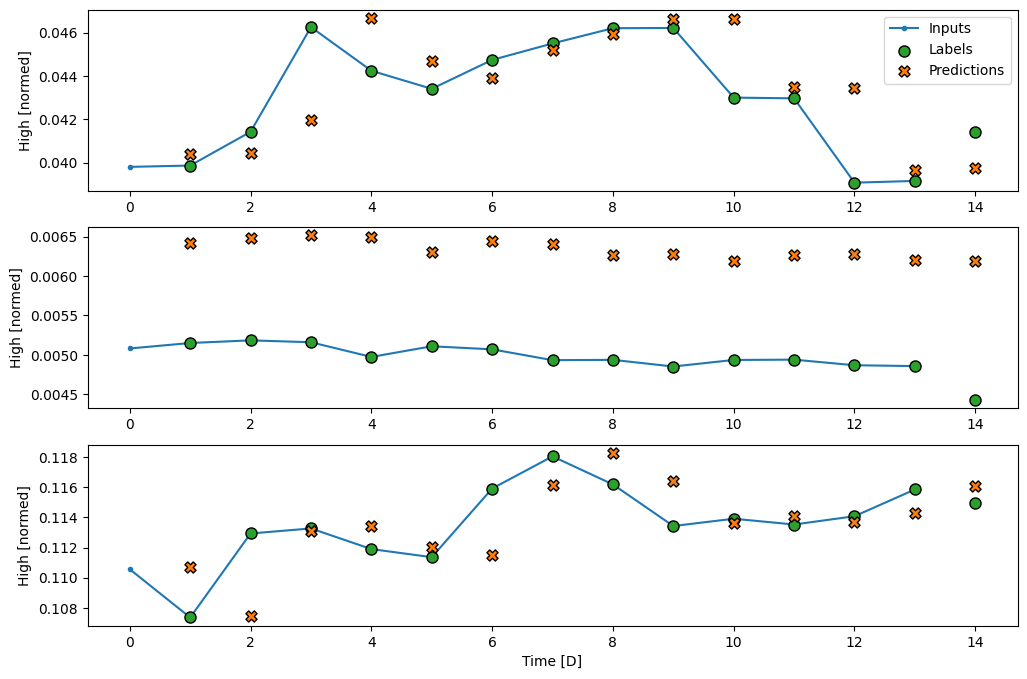

In [7]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()

train_performance['Dense'] = dense.evaluate(single_step_window.train, return_dict=True)
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)
single_step_window.plot(dense)

22/22 [==============================] - 0s 5ms/step - loss: 2.3787e-04 - mean_absolute_error: 0.0147


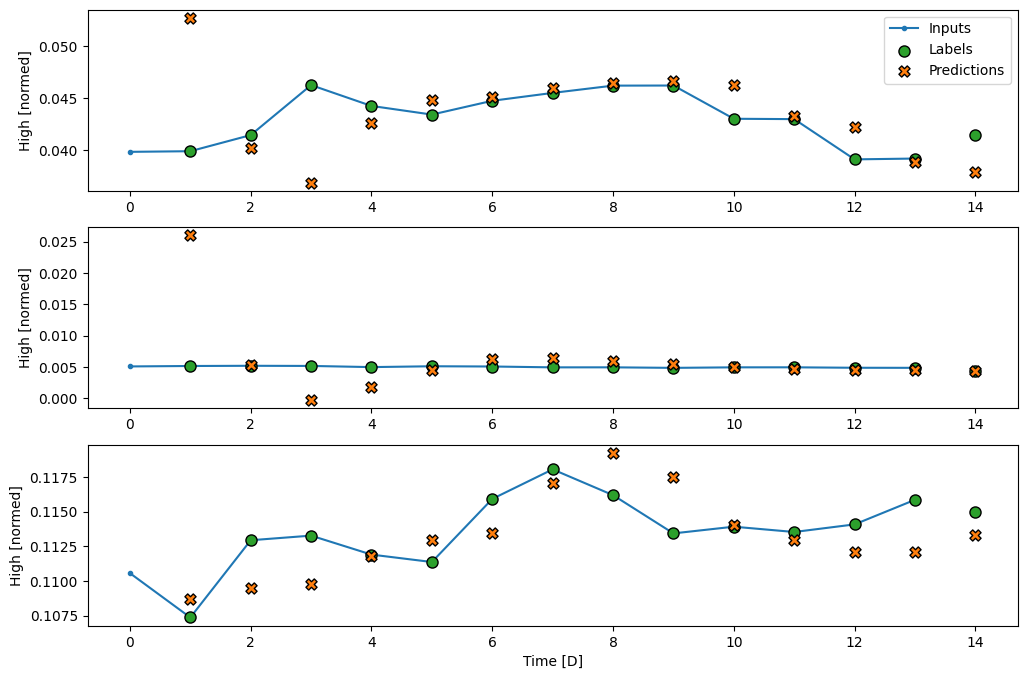

In [8]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, single_step_window)

IPython.display.clear_output()

train_performance['LSTM'] = lstm_model.evaluate(single_step_window.train, return_dict=True)
val_performance['LSTM'] = lstm_model.evaluate(single_step_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(single_step_window.test, verbose=0, return_dict=True)
single_step_window.plot(lstm_model)

22/22 [==============================] - 0s 4ms/step - loss: 1.3256e-04 - mean_absolute_error: 0.0107


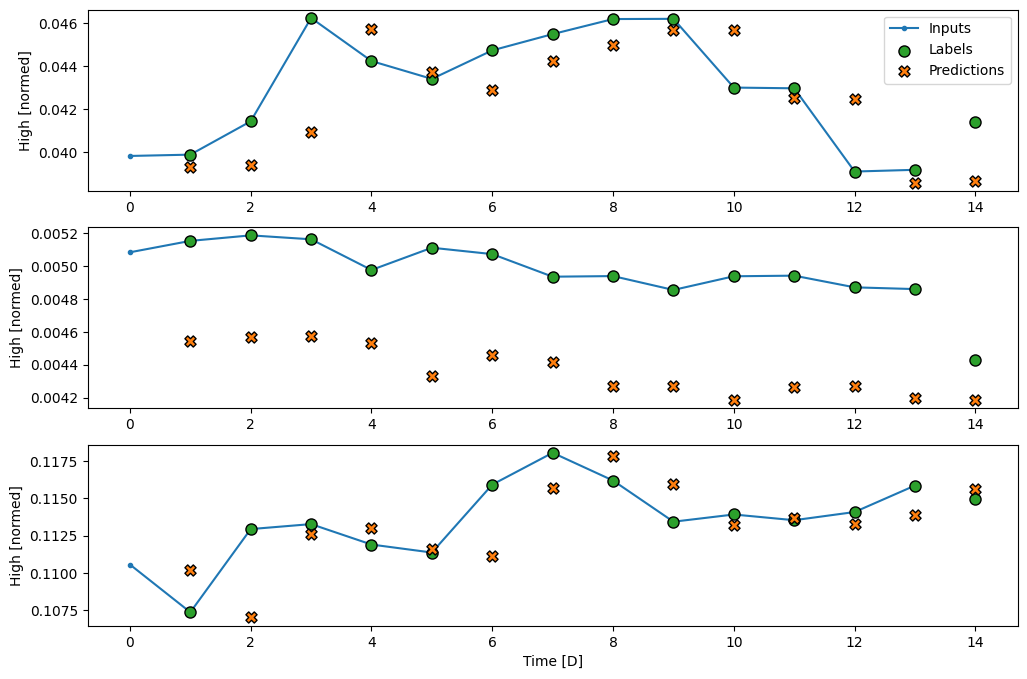

In [12]:
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, single_step_window)

IPython.display.clear_output()
train_performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.train, return_dict=True)
val_performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(single_step_window.test, verbose=0, return_dict=True)
single_step_window.plot(residual_lstm)


In [13]:
val_performance

{'Baseline': {'loss': 0.0001309217041125521,
  'mean_absolute_error': 0.010597842745482922},
 'Linear': {'loss': 0.00013379195297602564,
  'mean_absolute_error': 0.010792046785354614},
 'Dense': {'loss': 0.00013976583431940526,
  'mean_absolute_error': 0.011273481883108616},
 'LSTM': {'loss': 0.0002378704957664013,
  'mean_absolute_error': 0.014667346142232418},
 'Residual LSTM': {'loss': 0.00013256380043458194,
  'mean_absolute_error': 0.010696575976908207}}

Baseline    : 0.0068
Linear      : 0.0070
Dense       : 0.0082
LSTM        : 0.0116
Residual LSTM: 0.0069


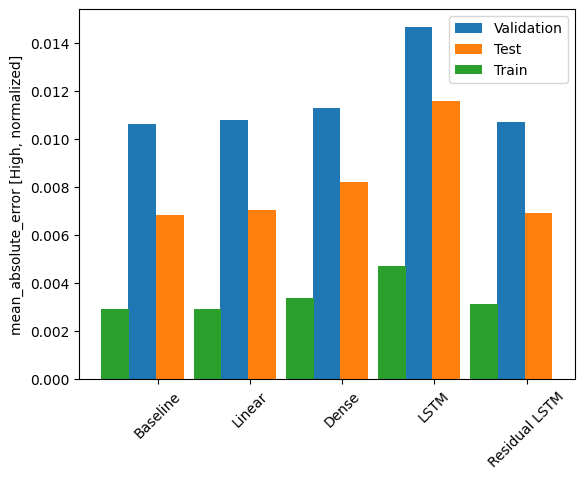

In [14]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
train_mae = [v[metric_name] for v in train_performance.values()]
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.ylabel('mean_absolute_error [High, normalized]')

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.13, test_mae, width, label='Test')
plt.bar(x - 0.46, train_mae, width, label='Train')

plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:12s}: {value[metric_name]:0.4f}')